- 이미지 인식
    - 시각 피질 작동원리
        - 시각 인지 과정
            - 계층적으로 발생한다
            - 눈의 앞층에 존재하는 세포들은ㅇ 이미지의 극히 일부분만 인식
            - 뒤로 갈수록 복잡한 세포들은 조금더 큰 영역의 이미지를 인식
        - 시각의 여러 세포들은 각자 다른 부분을 인지한다
            - 지형학적인 매필이 발생한다        
- 이미지 데이터 -> 숫자로 전환-> 컴퓨터는 숫자만 인식
    - 높이, 너비, 채널 -> 3차원 텐서로 구성
        - 높이 : 세로길이의 픽셀수
        - 너비 : 가로길이의 픽셀수
        - 채널 : 색의 성분
            - 흑백 : 채널수 1 -> 0~255
            - 칼라 : 채널수 3 -> Red, Green, Blue

- python에서 이미지 처리
- Pillow를 사용
- Pillow 이전에는 PIL(Python Image Library)이 패키지를 대체
    - JPEG, BPM, GIF, PNG, PPM, TIFF, BMP등 다양한 포멧 지원
    - PIL 패키지의 대체이므로 이름이 동일

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

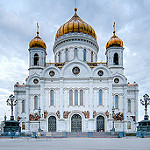

In [2]:
img = Image.open( './8.cnn_building.jpg' )
img

In [3]:
import numpy as np

In [4]:
np.array( img ).shape, type(img), img.size

((150, 150, 3), PIL.JpegImagePlugin.JpegImageFile, (150, 150))

In [5]:
# (150, 150, 1) => 마지막 1(흑백)은 의미가 없어서 삭제
# 흑백 처리
img = img.convert( 'L' )
np.array( img ).shape, type(img), img.size

((150, 150), PIL.Image.Image, (150, 150))

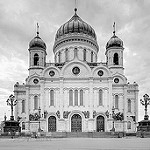

In [6]:
img

In [7]:
import torch

In [8]:
img_tensor = torch.Tensor( np.array( img ) )
img_tensor

tensor([[212., 213., 215.,  ..., 197., 199., 200.],
        [215., 216., 216.,  ..., 197., 199., 200.],
        [213., 214., 215.,  ..., 196., 197., 198.],
        ...,
        [170., 170., 171.,  ..., 163., 166., 161.],
        [174., 174., 174.,  ..., 172., 174., 167.],
        [168., 168., 168.,  ..., 157., 158., 149.]])

- 합성곱연산
    <img src='./8.합성곱연산_모서리탐지.jpeg'>
- 작은 커널(kernel or filter or 가중치)로 전체 이미지를 처음부터 끝가지 스캔하는 과정
- 5x5x1 인 이미지를  3x3 커널(윈도우)로 1x1로 스캔(슬라이딩)하면 총 9번이 수행된다
    - (5-3+1) * (5-3+1) = 9
    - 이런 스캐닝을 슬라이딩이라고 정의

In [9]:
# 이미지 샘플
ex_img = np.array( [
    [13, 1,  2,  1,  2],
    [12, 15, 15, 1,  2],
    [1,  0,  15, 2,  1],
    [3,  2,  1,  12, 11],
    [2,  2,  3,  1,  10]
] )
ex_img_tensor = torch.Tensor( ex_img )
ex_img_tensor

tensor([[13.,  1.,  2.,  1.,  2.],
        [12., 15., 15.,  1.,  2.],
        [ 1.,  0., 15.,  2.,  1.],
        [ 3.,  2.,  1., 12., 11.],
        [ 2.,  2.,  3.,  1., 10.]])

In [10]:
ex_img_tensor.size()

torch.Size([5, 5])

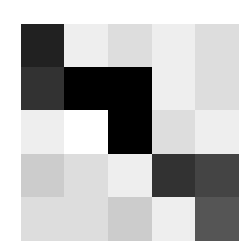

In [11]:
_, ax = plt.subplots(1,1)
ax.matshow( ex_img, cmap='binary' )
ax.axis('off')
plt.show()

In [12]:
# 커널 3x3
kernel = torch.Tensor( [
    [ 1, 0, -1],
    [ 1, 0, -1],
    [ 1, 0, -1]
] )
kernel.size()

torch.Size([3, 3])

In [13]:
# (데이터가 몇개냐? = 1차원의 성분수, 2차원의 성분수)
kernel.size(0)

3

In [14]:
# 합성곱 연산 구현
def convolution_operation( x_input, kernel ):
    # x의 크기 획득
    y, x = x_input.size()
    # 커널의 사이즈중 y축에 해당되는 값
    k_y, k_x = kernel.size()
    # 합성곱 연산을 하면으로 그결과를 담는 그릇
    convs = []
    '''
    for i in range(y-k_y+1):
        # 구성요소중, 같은 자리에 있는 원소끼리 곱해서 모두 더한다
        #c = [ torch.sum( x의슬라이싱한값*커널 ) for j in range(x-k_x+1) ]
        c = [ torch.sum( x_input[i:i+k_y , j:j+k_x] * kernel ) for j in range(x-k_x+1) ]
        convs.append( c )
    '''
    for i in range(y-k_y+1):
        c = []
        for j in range(x-k_x+1):
            # 합성곱
            c.append( torch.sum( x_input[i:i+k_y , j:j+k_x] * kernel ) ) 
            # 최대 풀링
            #c.append( torch.max( x_input[i:i+k_y , j:j+k_x] * kernel ) ) 
            # 최소 풀링
            #c.append( torch.min( x_input[i:i+k_y , j:j+k_x] * kernel ) ) 
        convs.append( c )
    # 텐서화
    return torch.Tensor( convs )

In [15]:
def convolution_operation( x_input, kernel ):
    y, x     = x_input.size()
    k_y, k_x = kernel.size()
    convs = []
    for i in range(y-k_y+1):
        c = []
        for j in range(x-k_x+1):
            c.append( torch.sum( x_input[i:i+k_y , j:j+k_x] * kernel ) ) 
        convs.append( c )
    return torch.Tensor( convs )

In [16]:
convs = convolution_operation( ex_img_tensor, kernel )
convs.size(), np.array( convs )

(torch.Size([3, 3]), array([[ -6.,  12.,  27.],
        [-15.,   2.,  17.],
        [-13., -11.,  -3.]], dtype=float32))

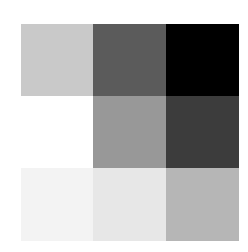

In [17]:
# 이미지가 합성곱층을 통과하여 만들어진 이미지
_, ax = plt.subplots(1,1)
ax.matshow( convs, cmap='binary' )
ax.axis('off')
plt.show()

In [18]:
# 지금 사용한 커널이 수직 커널이다
# 샘플 이미지에 수직 커널을 적용해서 확인
vertical_convs = convolution_operation( img_tensor, kernel)

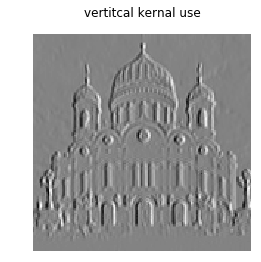

In [19]:
_, ax = plt.subplots(1,1)
ax.matshow( vertical_convs.numpy(), cmap='binary' )
ax.axis('off')
ax.set_title('vertitcal kernal use')
plt.show()

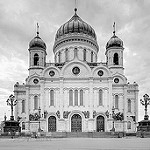

In [20]:
img

In [21]:
# 수직 커널을 수평 커널로 축을 회전시켜서 생성
horizental_kernel = kernel.t()

In [22]:
horizental_kernel

tensor([[ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [-1., -1., -1.]])

In [23]:
horizental_convs = convolution_operation( img_tensor, horizental_kernel)

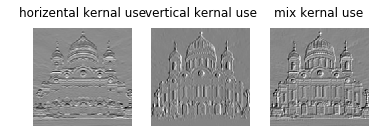

In [24]:
_, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.matshow( horizental_convs.numpy(), cmap='binary' )
ax1.axis('off')
ax1.set_title('horizental kernal use')

ax2.matshow( vertical_convs.numpy(), cmap='binary' )
ax2.axis('off')
ax2.set_title('vertical kernal use')

ax3.matshow( (horizental_convs+vertical_convs).numpy(), cmap='binary' )
ax3.axis('off')
ax3.set_title('mix kernal use')

plt.show()

<img src='./8.이미지처리.jpeg'>

- 입출력 텐서
    - B:batch, 배치크기
    - C:채널수(입력채널, 출력채널)
    - H:이미지 높이
    - W:이미지의 너비

In [26]:
import torch
import torch.nn as nn

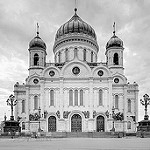

In [27]:
img

In [29]:
img_tmp = np.array( img )
h, w = img_tmp.shape

In [30]:
# [배치파일, 채널수, 이미지높이, 이미지너비]
# expand() 행렬을 확장하는 함수
# 확장한 이유는  API를 써서 컨볼류젼을 생성할것인데, 파라미터가 이런 형태를 원한다
img_tensor = torch.Tensor( img_tmp ).expand( 1, 1, h, w )
img_tensor.size()

torch.Size([1, 1, 150, 150])

In [31]:
batch, in_channels, height, width = img_tensor.size()

# 출력채널, 커널사이즈, 스프라이드 값은 설정
out_channels = 1
kernal_size  = 3
stride       = 1

- 합성곱층 생성 : nn.Conv2d
in_channels (int) 입력 채널수
out_channels (int) 출력 채널수
kernel_size (int or tuple) 커널의 크기
stride (int or tuple, optional) 윈도우 슬라이딩의 보폭의 크기
bias (bool, optional)  Default: True

In [34]:
conv_layer = nn.Conv2d( in_channels  = in_channels,
                        out_channels = out_channels,
                        kernel_size  = kernal_size,
                        stride       = stride,
                        bias         = False
                      )

In [35]:
conv_layer, type(conv_layer)

(Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False),
 torch.nn.modules.conv.Conv2d)

In [37]:
# 수직커널
kernel

tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])

In [40]:
kernel_height, kernel_width = kernel.size()

In [41]:
# 수직커널을 입력 형식와 동일하게 맞추겟다 -> 4-Tensor로 확장
conv_layer.weight.data = kernel.expand( 1, 1, kernel_height, kernel_width )

In [43]:
conv_layer, conv_layer.weight.data.size()

(Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False),
 torch.Size([1, 1, 3, 3]))

In [45]:
img_tensor.size()

torch.Size([1, 1, 150, 150])

In [44]:
# 합성곱 연산
convs = conv_layer( img_tensor )
convs.size()

torch.Size([1, 1, 148, 148])

- 합성곱층을 통과한 이미지의 W(out), H(out)은
    - H(out) = (H(in) + 2*P - K)/S + 1
        - (150 + 2*0 - 3)/1 + 1 = 147/1 + 1 = 148
    - W(out) = (W(in) + 2*P - K)/S + 1
        - (150 + 2*0 - 3)/1 + 1 = 147/1 + 1 = 148
    -> 출력 텐서는 
        (B, C(out), H(out), W(Out) => (1, 1, 148, 148)

- K : 커널 크기
- S : 스트라이드(stride)
    - 커널을 이동시키는 보폭

- P : 패딩, padding
    - 이미지의 테두리 주변에 가상의 테두리르 붙인다
    - 통상적으로 패딩은 0
    - 합성곱 연산을 계속 수행하면, 크기가 줄어들어, 홀수번째등, 비워 있는 공간이 생기게 되므로, 이를 보정하기 위한 조치
    - 통상적으로 테두리쪽이 영향을 받는다. 
    <img src='./8.padding.jpeg' width='150'>

In [46]:
convs.size()

torch.Size([1, 1, 148, 148])

In [48]:
# 시각화를 하기위해서 1, 1, 차월을 제거한다 -> 
convs.squeeze().size()

torch.Size([148, 148])

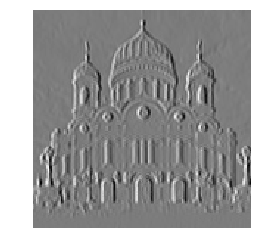

In [49]:
# detach() 이미지 데이터 추출
plt.imshow( convs.squeeze().detach().numpy(), cmap='gray' )
plt.axis('off')
plt.show()

In [50]:
# 활성화 함수를 거쳐서 합성곱층을 완성 -> 렐루
activations_maps = torch.relu( convs )
# 경계선이 조금더 명확해 졌다

In [51]:
activations_maps.size()

torch.Size([1, 1, 148, 148])

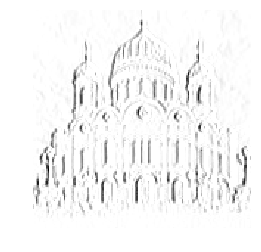

In [53]:
plt.imshow( activations_maps.squeeze().detach().numpy(), cmap='binary' )
plt.axis('off')
plt.show()

- 풀링층
    - 활성화된 이미지의 크기를 줄여서 연산 속도를 더 빠르게 가져간다
    - 특징을 유지하면서
    - 활성화맵의 특징을 더 잘 검출할수 있다
    <img src='./8.pooling.jpeg' width='300'>
    <img src='./8.pooling2.jpeg' width='300'>

In [57]:
# 커널 사이즈 조정 : 설정
kernal_size  = 2
b, c, height, width = activations_maps.size()
b, c, height, width

(1, 1, 148, 148)

In [58]:
# unfold( 차원의인덱스, 커널사이즈, 커널사이즈 ) 
# 결과로 해당 차원이 줄어들고, 텐서 맨 뒤에 커널사이즈 삽입이 된다
activations_maps.unfold(2, kernal_size, kernal_size).size()

torch.Size([1, 1, 74, 148, 2])

In [60]:
activations_maps.unfold(2, kernal_size, kernal_size).unfold(3, kernal_size, kernal_size).size()

torch.Size([1, 1, 74, 74, 2, 2])

In [61]:
torch.Tensor([ [1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [63]:
torch.Tensor([ [1,2,3],[4,5,6]]).max(-1)[0]

tensor([3., 6.])

In [65]:
activations_maps.unfold(2, kernal_size, 
                        kernal_size).unfold(3, kernal_size, 
                                            kernal_size).max(-1)[0].max(-1)[0].size()

torch.Size([1, 1, 74, 74])

In [68]:
# 직접 구현한다면
def pooling( x, kernal_size, stride=None, type='max'):
    # 스트라이드르 제시 하지 않으면 커널 크기와 동일하게 설정
    if not stride:
        stride = kernal_size
    
    tmp = x.unfold(2, kernal_size, kernal_size).unfold(3, kernal_size, kernal_size)
    if type == 'max':    # 최대 풀링
        pool = tmp.max(-1)[0].max(-1)[0]
    elif type == 'min':  # 최소 풀링
        pool = tmp.min(-1)[0].min(-1)[0]
    elif type == 'mean':  # 평균 풀링
        pool = tmp.mean(-1)[0].mean(-1)[0]
    else:
        pool = None
    return pool

In [69]:
maxpools = pooling( activations_maps, kernal_size=2)
maxpools.size()

torch.Size([1, 1, 74, 74])

In [70]:
# API로 구현
maxool_layer = nn.MaxPool2d( kernel_size=2, stride=2 )
maxool_layer

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [71]:
maxpools = maxool_layer(  activations_maps )
maxpools.size()

torch.Size([1, 1, 74, 74])

In [ ]:
(148 + 2*0 - 2) / 2 + 1 = 146/2 +1 = 73 +1= 74

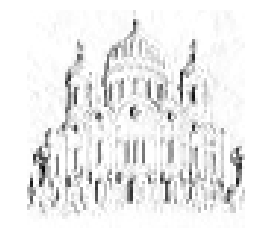

In [72]:
plt.imshow( maxpools.squeeze().detach().numpy(), cmap='binary' )
plt.axis('off')
plt.show()